In [1]:
import os,sys
import ROOT
import json
import logging
from array import array
import tdr as tdrStyle
from lumi import CMS_lumi
from ratio import createRatio

Welcome to JupyROOT 6.28/06


In [2]:
logging.basicConfig(level=logging.DEBUG)

def checkfile(file):
    if not os.path.isfile(file):
        raise Exception('{file} not existed'.format(file=file))


def sethiststyle(hist, color, Xtitle=' ', Ytitle=' ', ratio=1):
    if color != 1:
        hist.SetFillColor(color)
        hist.SetLineColor(0)
        hist.SetLineWidth(0)
    else:
        hist.SetLineWidth(2)
        hist.SetLineColor(1)
    hist.SetMarkerStyle(20)
    hist.SetMarkerColor(1)
    hist.SetYTitle('Events/bin')
    hist.SetStats(0)
#    hist.Sumw2()

    # Adjust y-axis settings
    # hist.GetYaxis().SetNdivisions(105)
    hist.GetYaxis().SetTitleSize(38)
    hist.GetYaxis().SetTitleFont(43)
    hist.GetYaxis().SetTitleOffset(1.50)
    hist.GetYaxis().SetLabelFont(43)
    hist.GetYaxis().SetLabelSize(38)
    hist.GetYaxis().SetLabelOffset(0.015)

    # Adjust x-axis settings
    hist.SetXTitle(str(Xtitle))
#    hist.GetXaxis().SetTitleSize(38)
    hist.GetXaxis().SetTitleSize(0)
    hist.GetXaxis().SetTitleFont(43)
    hist.GetXaxis().SetTitleOffset(6.2)
    hist.GetXaxis().SetLabelFont(43)
    hist.GetXaxis().SetLabelSize(18)
    hist.GetXaxis().SetLabelOffset(0.015)

tdrStyle.setTDRStyle()
tdrStyle.gtdr()


In [3]:
final_hists = {
    'VV':{
        'name':'VV',
        'color':'#1f77b4',
    },
    'VG':{
        'name':'VG',
        'color':'#2ca02c',
    },
    'VVV':{
        'name':'VVV',
        'color':'#9467bd',
    },
    'Top':{
        'name':'Top',
        'color':'#ff7f0e',
    },
    'FakeLep':{
        'name':'FakeLep',
        'color':'#bcbd22',
    },
    'FakePho':{
        'name':'FakePho',
        'color':'#17becf',
    },
    'WZG':{
        'name':'WZG',
        'color':'#d62728'
    }
}

json_path = "combine_shape_fullrun2.json"
#json_path = "combine_shape_18.json"
root_path = "freezed_PSmodified/RunII/fitDiagnosticsTest.root"
#root_path = "freezed_PSmodified_unblind/2018/fitDiagnosticsTest.root"


checkfile(json_path)
checkfile(root_path)


In [4]:
json_path

'combine_shape_fullrun2.json'

In [5]:
## Full Run-II
with open(json_path) as f:
    jsons = json.load(f)
    f.close()


total_bin = 0
for region in jsons['regions']:
    if '2016'in region:
        region = jsons['regions'][region]
        bin_array = region['bin_array']
        total_bin += len(bin_array) - 1


tag = jsons['utils']['tag']
print(total_bin)
file = ROOT.TFile(root_path,'OPEN')
Xtitle='m_{lll} [GeV]'

18


Warning in <TClass::Init>: no dictionary for class RooList is available


---
## 2. Makehist

In [6]:
# Create stack for global plot
h_stack = ROOT.THStack("","")
h_mc = ROOT.TH1D("", "", total_bin, 0, total_bin)
h_mc.SetFillColor(ROOT.kGray+2)
h_mc.SetFillStyle(3345)
h_mc.SetMarkerSize(0.)
h_mc.SetMarkerColor(ROOT.kGray+2)
h_mc.SetLineWidth(0)
h_data = ROOT.TH1D("", "", total_bin, 0, total_bin)
sethiststyle(h_data, 1, ratio=0.7, Xtitle=Xtitle)
# Create line for global plot
lines = []
# Create text for global plot
texts = []
titles = []


# Create Legend for global plot
legend = ROOT.TLegend(0.20, 0.55, 0.90, 0.80)
legend.SetNColumns(3)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetTextSize(0.055)
legend.SetLineWidth(1)
legend.SetLineStyle(0)


### Get MC

In [7]:
import math
def GET_MC_HIST(process ,h_mc, year, draw_legend=False):
    
    
    hist_temp = ROOT.TH1D("", "", total_bin, 0, total_bin)
    process = final_hists[process]
    process_name = process['name']

    global_bin_count = 1
    # Load every region --> SR CR1 CR2...
    for region in jsons['regions']:

        if not year in region: continue; # >> year condition (only for RunII full data)

        region = jsons['regions'][region]
        region_name = region['final_name']
        variable = region['variable_storename']
        bin_array = region['bin_array']
        
        
        if not process_name in region['processes']: ## >> process (WZG VG VV FakePhoton FakeLepton...)
            logging.info("{process} not included in {region}".format(process=process['name'], region=region['final_name']))
            global_bin_count += len(bin_array) - 1
            continue

        total_bin_content = 0
        total_bin_error = 0
        # Load every bin --> bin 1 2 3...
        for bin in range(1, len(bin_array)):
            #branch_name = '{region_name}_{variable}_bin{bin}_{tag}'.format(region_name=region_name, variable=variable, bin=str(bin), tag=tag)
            
            # -- pre-fit
            branch = file.shapes_prefit.Get(f'{region_name}')
            # --post-fit
            #branch = file.shapes_fit_s.Get(f'{region_name}')

            if hasattr(branch, process_name):
                bin_content = branch.Get(process_name).GetBinContent(bin)
                bin_error   = branch.Get(process_name).GetBinError(bin)
                hist_temp.SetBinContent(global_bin_count, bin_content)
                hist_temp.SetBinError(global_bin_count, bin_error)
            else:
                logging.warning(f"{process_name} not exist in {region_name}")
                pass
            total_bin_content += bin_content
            total_bin_error = math.sqrt(bin_error**2 + total_bin_error**2)
            global_bin_count += 1

        if "SR" in region_name:
            print(region_name,total_bin_content,total_bin_error)
    #sethiststyle(hist_temp, process['color'], ratio=0.7)
    sethiststyle(hist_temp, ROOT.TColor.GetColor(process['color']), ratio=0.7)

    if draw_legend:
        legend.AddEntry(hist_temp, process['name'], 'F')
    h_mc.Add(hist_temp)
    
    return hist_temp


In [8]:
cls=0
for process in final_hists:
    for year in ['2016','2017','2018']:
        print(f"--- {process} ---")
        if cls in list(range(0,21,3)):
            h_stack.Add(GET_MC_HIST(process ,h_mc, year, draw_legend=True))
        else:
            h_stack.Add(GET_MC_HIST(process ,h_mc, year, draw_legend=False))
        cls+=1

# --> only for 2018
#for process in final_hists:
#    print(f"--- {process} ---")
#    h_stack.Add(GET_MC_HIST(process ,h_mc, '2018', draw_legend=True))


print(h_stack.GetMaximum())
print(h_mc.GetMaximum())

INFO:root:FakePho not included in CR1_2016
INFO:root:FakePho not included in CR3_2016
INFO:root:FakePho not included in CR1_2017
INFO:root:FakePho not included in CR3_2017
INFO:root:FakePho not included in CR1_2018
INFO:root:FakePho not included in CR3_2018


--- VV ---
SR_2016 3.030780851840973 0.486520159085138
--- VV ---
SR_2017 4.474452584981918 0.7327553244859015
--- VV ---
SR_2018 6.299349904060364 0.25239663145737057
--- VG ---
SR_2016 0.1113839467498321 0.18233470590320056
--- VG ---
SR_2017 0.3229154676396636 0.3788528750864954
--- VG ---
SR_2018 1.4013480852113496 1.2116307869224683
--- VVV ---
SR_2016 0.4878529980778694 0.25082699842680617
--- VVV ---
SR_2017 0.5094005391001701 0.26058802930209346
--- VVV ---
SR_2018 0.7701573073863983 0.03973813926336177
--- Top ---
SR_2016 0.849784754216671 0.3563869112848082
--- Top ---
SR_2017 0.8941448777914047 0.1918141972941221
--- Top ---
SR_2018 1.5288983136415482 0.6688988172425147
--- FakeLep ---
SR_2016 2.930984616279602 3.2815115920650686
--- FakeLep ---
SR_2017 6.1417515883909 3.3632535522596436
--- FakeLep ---
SR_2018 7.066616535186768 4.713658117159006
--- FakePho ---
SR_2016 4.365493357181549 1.3238572212864557
--- FakePho ---
SR_2017 7.763314127922058 1.81084516024893
--- FakePh

### Get data

In [9]:
import math
def GET_DATA_HIST(h_data, year, draw_style=False, show_x_label=True):
    # get data (asimov when blinded)
    global_bin_count = 1
    hist_temp = ROOT.TH1D("", "", total_bin, 0, total_bin)
    
    # Load every region --> SR CR1 CR2...
    for region in jsons['regions']:  
        
        print("check global bin --> ",region,global_bin_count)
        if not year in region: continue; # year condition # --> only for RunII Full data
        
        region = jsons['regions'][region]
        region_name = region['final_name']
        variable = region['variable_storename']
        variable_plotname = region['variable_plotname']
        bin_array = region['bin_array']
        
        total_data=0
        total_data_error = 0
        # Load every bin --> bin1 bin2 bin3....
        for bin in range(0, len(bin_array)-1):
            branch_name = region_name
            if not hasattr(file.shapes_prefit, f'{branch_name}/data'): # Prefit
            #if not hasattr(file.shapes_fit_s, f'{branch_name}/data'): # Postfit

                logging.info(f"data not included in {region_name}")
                global_bin_count += 1
                continue

            branch = file.shapes_prefit.Get(branch_name) # Prefit
            #branch = file.shapes_fit_s.Get(branch_name) # Postfit

 
            bin_content = branch.Get('data').GetPointY(bin)
            bin_error = branch.Get('data').GetErrorY(bin)

            hist_temp.SetBinContent(global_bin_count, bin_content)
            hist_temp.SetBinError(global_bin_count, bin_error)

            
            if show_x_label:
                h_data.GetXaxis().SetBinLabel(global_bin_count, '[{left},{right})'.format(left=bin_array[bin], right=bin_array[bin+1]))
                h_data.GetXaxis().LabelsOption('v')
                hist_temp.GetXaxis().LabelsOption('v')
            total_data+=bin_content
            total_data_error = math.sqrt(bin_error**2 +total_data_error**2)
            global_bin_count += 1
    
        if "SR" in region_name:
            print(region_name,total_data,total_data_error)
            
        if draw_style:
            line_temp = ROOT.TLine(global_bin_count-1, 0, global_bin_count-1, 3.0*hist_temp.GetMaximum())
            line_temp.SetLineWidth(3)
            line_temp.SetLineColor(1)
            line_temp.SetLineStyle(2)
            lines.append(line_temp)

            text_name = region_name.split('_')[0]
            text_temp = ROOT.TText(global_bin_count-1-len(bin_array)/2, 4.0*hist_temp.GetMaximum(), text_name)
            text_temp.SetTextSize(40)
            text_temp.SetTextFont(43)
            texts.append(text_temp)

            title_temp = ROOT.TLatex(global_bin_count-len(bin_array)+0.2, -1, variable_plotname)
            title_temp.SetTextSize(35)
            title_temp.SetTextFont(43)
            titles.append(title_temp)
    h_data.Add(hist_temp)    
        
        
        

In [10]:
GET_DATA_HIST(h_data, '2018',False,False)
GET_DATA_HIST(h_data, '2017',False,False)
GET_DATA_HIST(h_data, '2016',True,True)

# 2018 only
#GET_DATA_HIST(h_data, '2018',True,True)

print(h_data.GetMaximum())

check global bin -->  CR1_2016 1
check global bin -->  CR2_2016 1
check global bin -->  CR3_2016 1
check global bin -->  SR1_2016 1
check global bin -->  CR1_2017 1
check global bin -->  CR2_2017 1
check global bin -->  CR3_2017 1
check global bin -->  SR1_2017 1
check global bin -->  CR1_2018 1
check global bin -->  CR2_2018 6
check global bin -->  CR3_2018 10
check global bin -->  SR1_2018 15
SR_2018 42.90616273880005 7.377520238048311
check global bin -->  CR1_2016 1
check global bin -->  CR2_2016 1
check global bin -->  CR3_2016 1
check global bin -->  SR1_2016 1
check global bin -->  CR1_2017 1
check global bin -->  CR2_2017 6
check global bin -->  CR3_2017 10
check global bin -->  SR1_2017 15
SR_2017 31.435476303100586 6.44427163846412
check global bin -->  CR1_2018 19
check global bin -->  CR2_2018 19
check global bin -->  CR3_2018 19
check global bin -->  SR1_2018 19
check global bin -->  CR1_2016 1
check global bin -->  CR2_2016 6
check global bin -->  CR3_2016 10
check global

Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Warning in <TAxis::Sort>: Cannot sort. No labels
Info in <TH1D::Add>: Attempt to add histograms with different labels - trying to use TH1::Merge
Warning in <Merge>: No

In [11]:
sum_=0
for i in [15,16,17,18,19]:
    sum_ +=h_data.GetBinContent(i)
print(sum_)

95.84633016586304


In [12]:
h_mc.GetMaximum()

736.4813287725183

In [13]:
# Blind -- SR 
#for i in [15,16,17,18]:
#    h_data.SetBinContent(i,0)

138 fb^{-1} RunII (13 TeV)


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Divide>: Dividing histograms with different labels
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


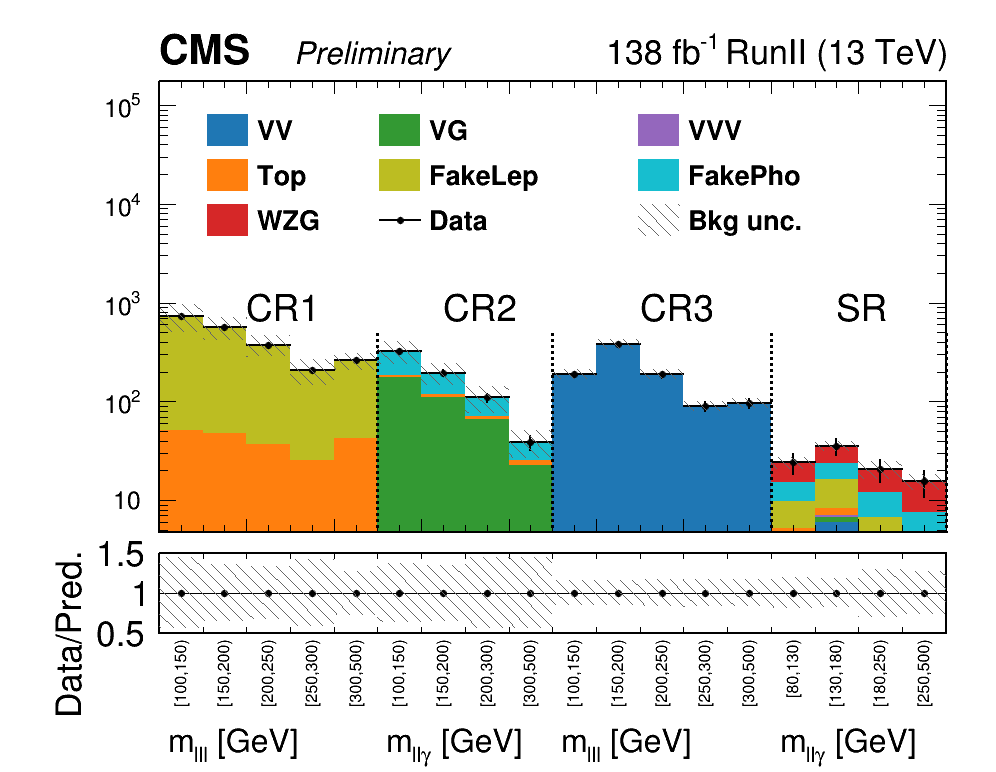

In [14]:
c1 = ROOT.TCanvas("","",1000,800)
c1.Draw()
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.30, 1, 1.00)
pad1.SetTopMargin(0.15)  # joins upper and lower plot
pad1.SetBottomMargin(0.015)  # joins upper and lower plot
pad1.SetLogy()
#pad1.SetGridx()
pad1.Draw()
# Lower ratio plot is pad2
c1.cd()  # returns to main canvas before defining pad2
pad2 = ROOT.TPad("pad2", "pad2", 0, 0.00, 1, 0.30)
pad2.SetTopMargin(0.055)  # joins upper and lower plot
pad2.SetBottomMargin(0.60)  # joins upper and lower plot

pad2.SetGridy()
pad2.Draw()

# Draw Everything
pad1.cd()

h_stack.Draw('HIST')
h_stack.SetMaximum(100000)
h_data.Draw('E0X0p SAME')
h_mc.Draw('e2 SAME')
legend.AddEntry(h_data, 'Data')
legend.AddEntry(h_mc, 'Bkg unc.', 'F')
legend.Draw('SAME')
for line in lines:
    line.Draw('SAME')
for text in texts:
    text.Draw('SAME')

h3 = createRatio(h_data, h_mc)
pad2.cd()
sethiststyle(h3, 1, ratio=0.28, Xtitle=Xtitle)
h3.SetYTitle('Data/Pred.')

h4 = createRatio(h_mc, h_mc)
sethiststyle(h4, 1, ratio=0.28, Xtitle=Xtitle)
#h3.Draw('E0X0p')
h3.SetLineColor(0)
h3.Draw('p SAME')

hline = ROOT.TLine(0,1,18,1)
hline.Draw()

h4.Draw('e2 SAME')
for title in titles:
    title.Draw("SAME")
CMS_lumi(pad1, 0, 0)
ROOT.gPad.RedrawAxis()
ROOT.gStyle.SetPadLeftMargin(0.15)
ROOT.gStyle.SetPadBottomMargin(0.50)


In [15]:
c1.Print("pretfit_2018.pdf")
c1.Print("prefit_2018.png")

Info in <TCanvas::Print>: pdf file pretfit_2018.pdf has been created
Info in <TCanvas::Print>: png file prefit_2018.png has been created


In [16]:
!ls

asimov_2018.pdf		     freezed_PSmodified
asimov_2018.png		     freezed_PSmodified_unblind
breakdown_unc.sh	     lumi.py
card_origin		     lumi.pyc
cards_map_2016.json	     N5_photonPT15_FakePhotonShape
cards_map_2017.json	     N6_PhotonPT20_FakePhotonShape
cards_map_2018.json	     Plot_asimov.ipynb
cards_map_fullrun2.json      plot_asimov.py
combine_CR_shape_16.csv      Plot_test.ipynb
combine_CR_shape_17.csv      postfit_2018.pdf
combine_CR_shape_18.csv      postfit_2018.png
Combine_help_shape.py	     prefit_2018.pdf
combine_logger.out	     prefit_2018.png
combine_shape_16.json	     pre_post_fit.py
combine_shape_17.json	     __pycache__
combine_shape_18.json	     ratio.py
combine_shape_fullrun2.json  ratio.pyc
combine_SR_shape_16.csv      Standard_results_beforePrV
combine_SR_shape_17.csv      store
combine_SR_shape_18.csv      tdr.py
combine_SR_shape_18_org.csv  tdr.pyc
data_open_231030	     test_breakdown
freezed			     test.sh
freezed_data
